# Application and optimization of ARMA model in stock price prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import lag_plot
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

## Data Preparation

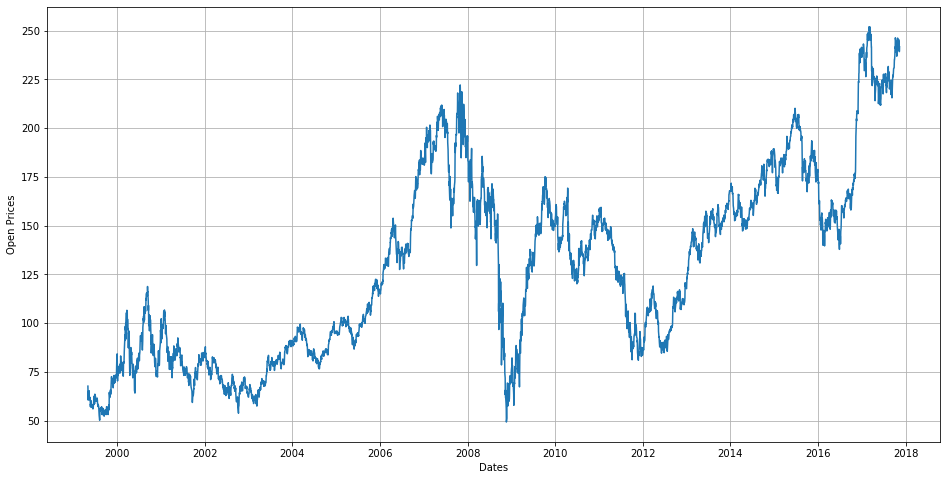

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/gs.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

## Autocorrelation process assumes that observation of previous several time steps are useful to predict the next step which is the correlation between the observations themselves.
## Calculate the correlation between output variables and several lagged values. AR process will get the lagged value with high correlation a greater weight in model.
## If there were low or none correlation between output variable and all the lagged values, this time-series might be unpredictable.  
## Hence before go on AR process, figuring out autocorrelation of the one-factor time series itself is necessary to do.

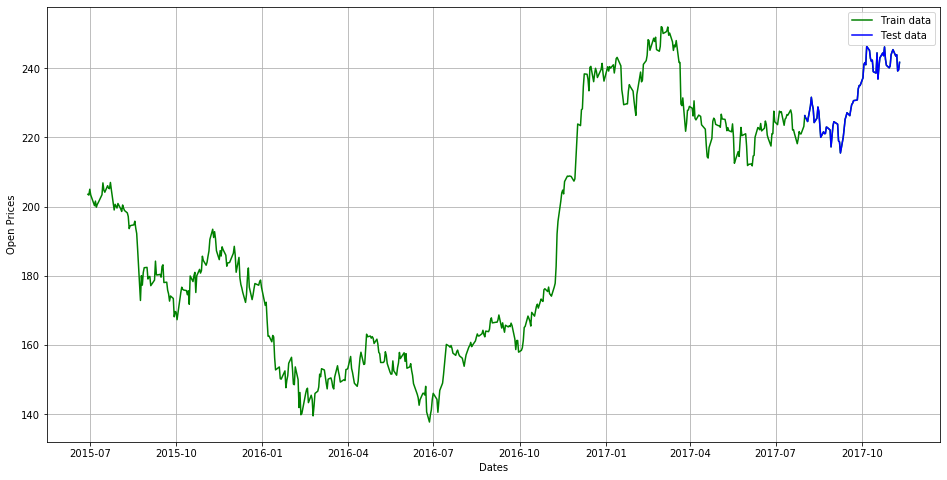

In [3]:
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

### The charts above shows a high correlation between y(t) and y(t+5).

No handles with labels found to put in legend.


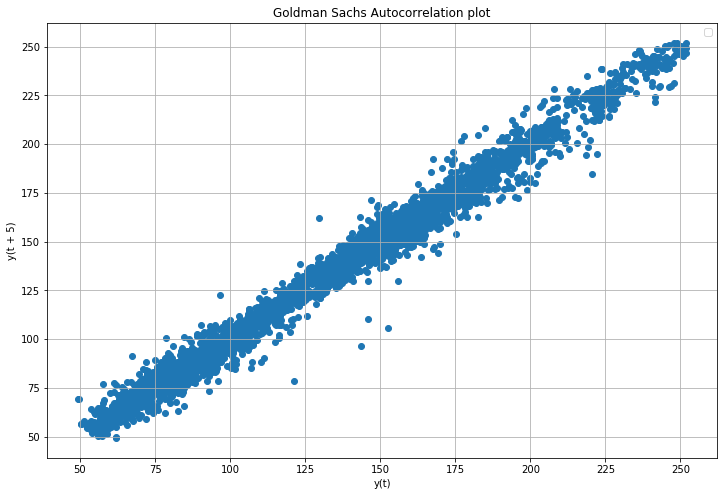

In [3]:
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=5)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend()

### Checking correlation by calculating covariance:

In [4]:
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

t       t+1       t+5      t+10      t+30
t     1.000000  0.994216  0.988282  0.956678  0.998288
t+1   0.994216  1.000000  0.992890  0.963463  0.992929
t+5   0.988282  0.992890  1.000000  0.971829  0.987001
t+10  0.956678  0.963463  0.971829  1.000000  0.954921
t+30  0.998288  0.992929  0.987001  0.954921  1.000000


# AR

C:\Users\JinYC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
Lag: 31
MSE: 9.182713320807808
MAE: 2.460056142380913
RMSE: 3.030299213082399


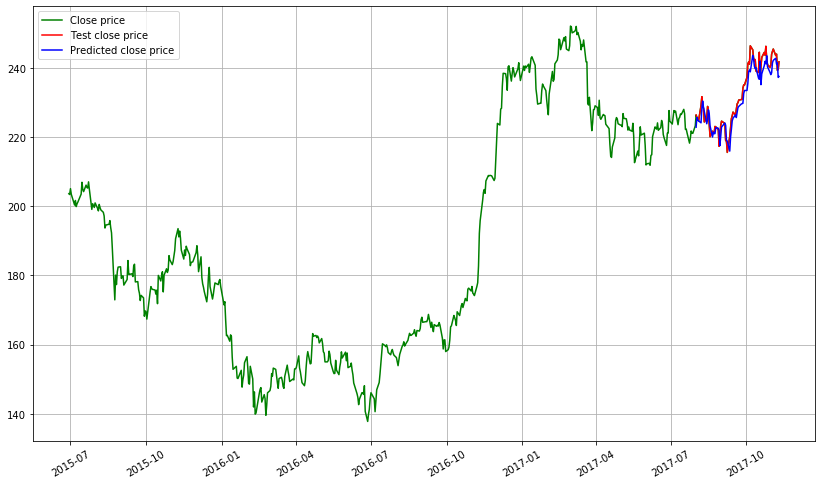

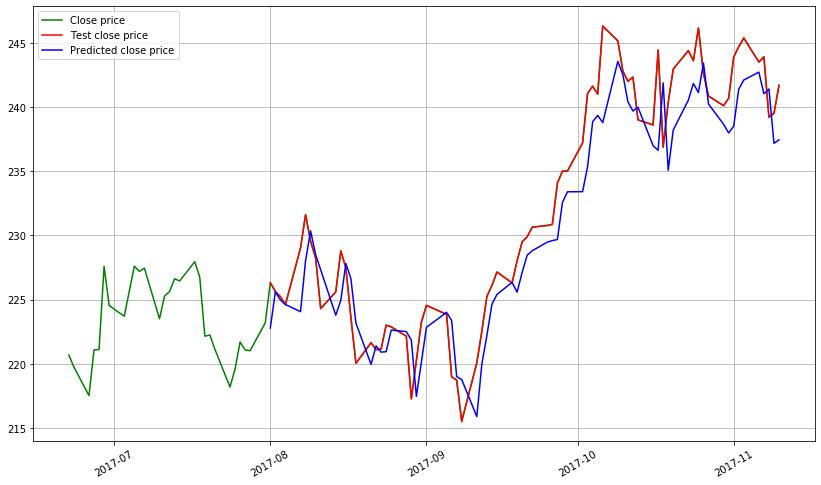

In [6]:
train_ar = train_data['Open']
test_ar = test_data['Open']

model = AR(train_ar)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
window = 1
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat+22)
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
print('MSE: '+str(mean_squared_error(test_data['Open'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['Open'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Open'], predictions))))

# MA

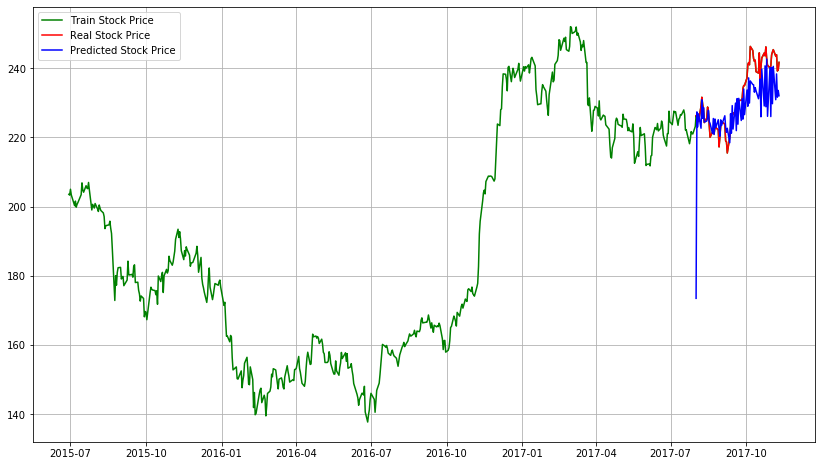

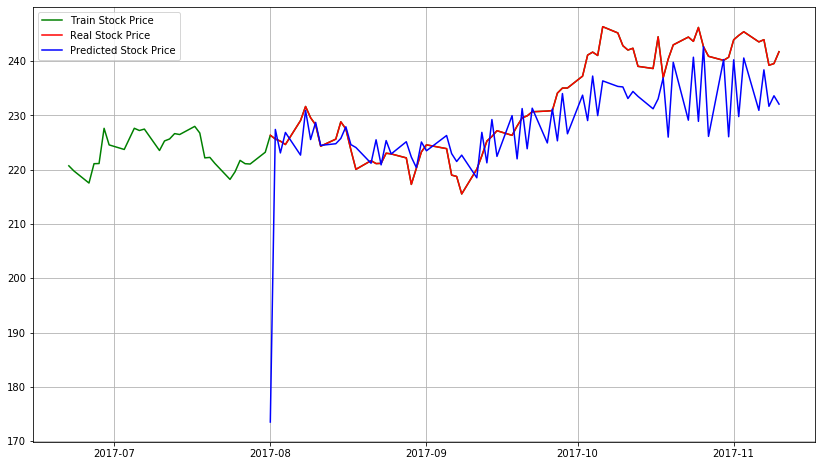

MSE: 83.67215858447196
MAE: 5.780447016729906
RMSE: 9.147248689331233


In [7]:
train_ma = train_data['Open']
test_ma = test_data['Open']
history = [x for x in train_ma]
y = test_ma
predictions = list()
model = ARMA(history, order=(0,1))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
for i in range(1, len(y)):
    model = ARMA(history, order=(0,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat+50)
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

# ARMA

## Two approaches for stationary.
### 1. Difference.


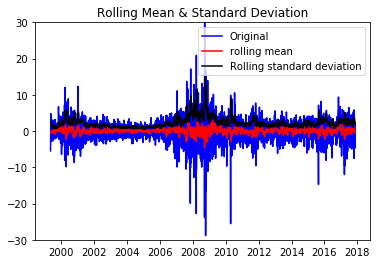

Results of Dickey-Fuller Test:
Test Statistic                -1.392256e+01
p-value                        5.263162e-26
#Lags Used                     1.900000e+01
Number of Observations Used    4.640000e+03
Critical value (1%)           -3.431760e+00
Critical value (5%)           -2.862163e+00
Critical value (10%)          -2.567102e+00
dtype: float64


In [8]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = data['Open']
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Both mean and variance amplitudes of the data reduced against time axis after difference. Dickey Fuller test showed the data is stationary in 90% confidence level.

### Figuring out p and q in ARMA ( p, q) by Autocorrelation Function and Partial Autocorrelation function.

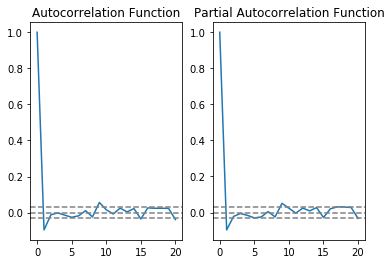

In [9]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

### ARMA process with data after difference:

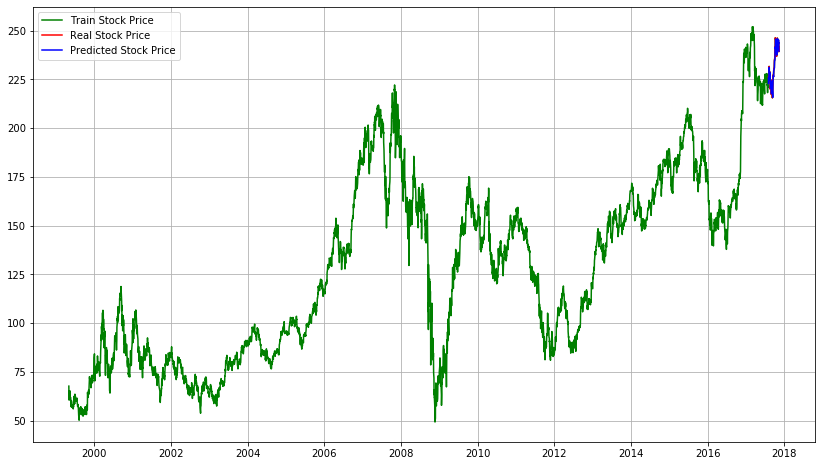

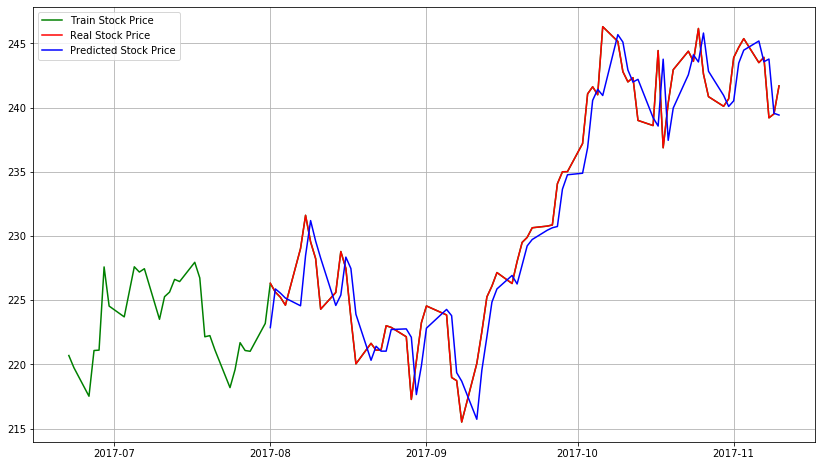

MSE: 6.7060167609099075
MAE: 2.031020223465372
RMSE: 2.589597799062609


In [10]:
train_arma = train_data['Open']
test_arma = test_data['Open']
history = [x for x in train_arma]
y = test_arma
predictions = list()
model = ARMA(history, order=(1,1))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
for i in range(1, len(y)):
    model = ARMA(history, order=(1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

## 2.Seasonal decomposition

<Figure size 1332x756 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

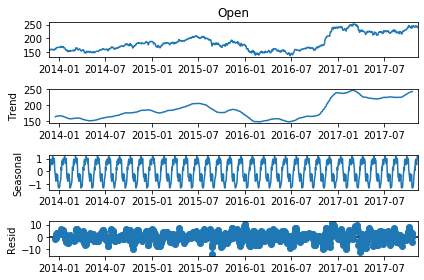

In [11]:
data_arima = data['Open']
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
decomposition = seasonal_decompose(data_arima[-1000:], model='additive', freq=30)
plt.figure(figsize=(20,10))
fig = decomposition.plot()
plt.show()

### Separate original data into three parts as shown in illustration. Residual is the rest of data which can be used in the model. It is stationary data after eliminating the other two parts.


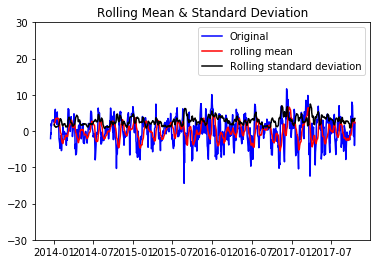

Results of Dickey-Fuller Test:
Test Statistic                -1.105648e+01
p-value                        4.930309e-20
#Lags Used                     7.000000e+00
Number of Observations Used    9.620000e+02
Critical value (1%)           -3.437166e+00
Critical value (5%)           -2.864549e+00
Critical value (10%)          -2.568372e+00
dtype: float64


In [12]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
residual = decomposition.resid
residual.dropna(inplace=True)
test_stationarity(residual)

### As shown in the charts, mean and variance have low volatility. And Dickey Fuller test showed the data is stationary in 99% confidence level.

### ARMA process with data with seasonal decomposition

In [13]:
trend = decomposition.trend
sea=decomposition.seasonal

In [14]:
train_trend, test_trend = trend[0:-73], trend[-73:]
train_sea, test_sea = sea[0:-73], sea[-73:]

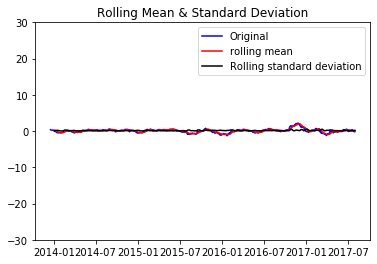

Results of Dickey-Fuller Test:
Test Statistic                  -5.159594
p-value                          0.000011
#Lags Used                      21.000000
Number of Observations Used    889.000000
Critical value (1%)             -3.437727
Critical value (5%)             -2.864797
Critical value (10%)            -2.568504
dtype: float64


In [15]:
def test_stationarity(timeseries):
    rolmean = pd.Series.rolling(timeseries,window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()
    fig = plt.figure()
    fig.add_subplot()
    orig = plt.plot(timeseries, color = 'blue',label='Original')
    mean = plt.plot(rolmean , color = 'red',label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label= 'Rolling standard deviation')
    plt.ylim([-30,30])
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)
ts_log = train_trend
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

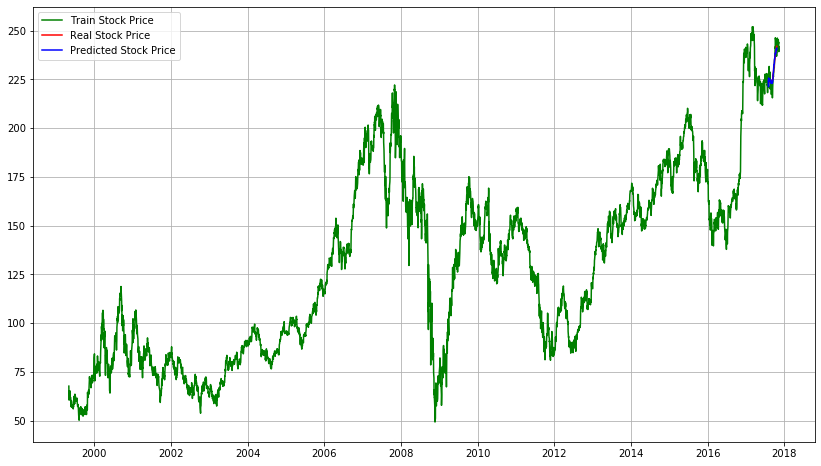

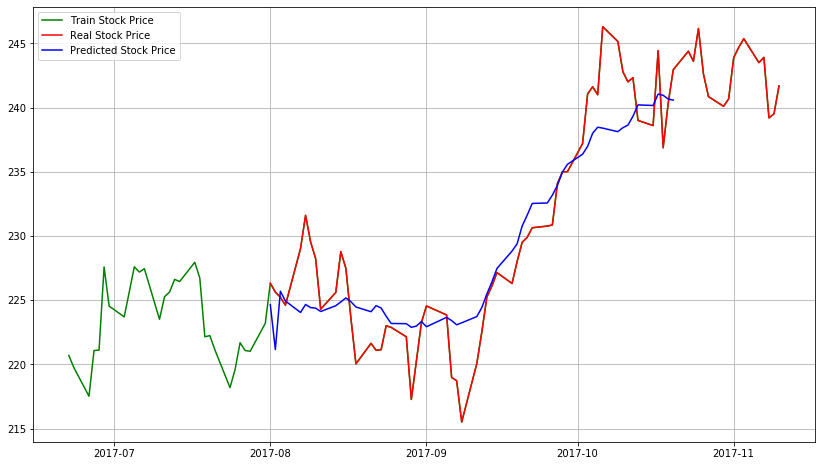

MSE: 0.8506116053086017
MAE: 0.781009121684144
RMSE: 0.9222860756341287


In [16]:
train_arima = train_trend.dropna()
test_arima = test_trend.dropna()
history = [x for x in train_arima]
y = test_arima
predictions = list()
model = ARIMA(history, order=(2,1,2))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0]+test_sea[0])
for i in range(1, len(y)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat+test_sea[i])
    obs = y[i]
    history.append(obs)
plt.figure(figsize=(14,8))
plt.plot(data.index, data['Open'], color='green', label = 'Train Stock Price')
plt.plot(y.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(y.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(data.index[-73:], data['Open'].tail(73), color = 'red', label = 'Real Stock Price')
plt.plot(y.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()
print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

# ARMA-GARCH

In [4]:
returns = pd.DataFrame(np.log(train_data['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)

In [5]:
from statsmodels.tsa.stattools import adfuller
returns_array_like = [x for l in returns.values for x in l]
_, pvalue, *_ = adfuller(returns_array_like)
print ('pvalue :',pvalue)

pvalue : 2.635655516449734e-19


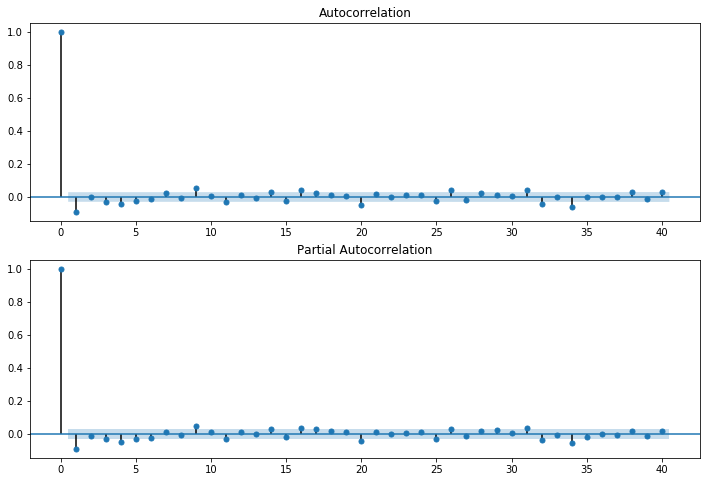

In [6]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returns.values, lags=40, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(returns.values, lags=40, alpha=0.05, ax=ax2)

In [7]:
import  statsmodels.tsa.stattools as sts
resid = sts.arma_order_select_ic(returns, max_ar=4, max_ma=4,ic=['aic','bic','hqic'], trend='nc', fit_kw=dict(method='css'))
print ('AIC-order :{}'.format(resid.aic_min_order))
print ('BIC-order :{}'.format(resid.bic_min_order))
print ('HQIC-order :{}'.format(resid.hqic_min_order))

AIC-order :(2, 3)
BIC-order :(1, 0)
HQIC-order :(2, 3)


In [8]:
arma_mod01 = sm.tsa.ARMA(returns, (1, 0)).fit()
print (arma_mod01.summary())
print ('-------------------------------------')
print (arma_mod01.params)

C:\Users\JinYC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
                              ARMA Model Results                              
Dep. Variable:        Log Return Rate   No. Observations:                 4587
Model:                     ARMA(1, 0)   Log Likelihood               10559.275
Method:                       css-mle   S.D. of innovations              0.024
Date:                Sun, 08 Mar 2020   AIC                         -21112.551
Time:                        21:50:03   BIC                         -21093.258
Sample:                             0   HQIC                        -21105.759
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
------

### autocorrelation test on the residuals

In [9]:
from statsmodels.stats import diagnostic
resid = arma_mod01.resid
_, pvalue, _, bppvalue = diagnostic.acorr_ljungbox(resid, lags=None, boxpierce=True)
print (pvalue,'\n',bppvalue)

[9.68824019e-01 7.38002070e-01 1.32949889e-01 2.84440667e-03
 1.33186601e-03 1.93964569e-03 1.88207072e-03 3.65743448e-03
 2.97808934e-05 5.85719812e-05 2.68536555e-05 4.50899232e-05
 8.78356755e-05 4.09685486e-05 4.59112330e-05 3.86004265e-06
 2.18642263e-06 3.02811370e-06 5.59659018e-06 1.56995052e-07
 2.01117735e-07 3.82418814e-07 5.30618837e-07 8.18796077e-07
 6.36024439e-07 1.34620090e-07 1.65525802e-07 1.07442764e-07
 1.29051064e-07 1.94974645e-07 3.91574182e-08 6.00279823e-09
 9.94558046e-09 5.46143834e-11 9.82326711e-11 1.80872655e-10
 3.27169390e-10 1.10008833e-10 1.88891054e-10 7.11725347e-11] 
 [9.68834205e-01 7.38197406e-01 1.33293206e-01 2.86949617e-03
 1.34655545e-03 1.96154942e-03 1.90546083e-03 3.70075479e-03
 3.05767667e-05 6.01038794e-05 2.76694176e-05 4.64506732e-05
 9.04079233e-05 4.23742565e-05 4.75500008e-05 4.05187976e-06
 2.30635499e-06 3.19590062e-06 5.90026130e-06 1.69317633e-07
 2.17141379e-07 4.12318683e-07 5.72408055e-07 8.83067236e-07
 6.89069600e-07 1.479

### test ARCH effect on the residuals

In [10]:
*_, fpvalue = diagnostic.het_arch(resid)
print (fpvalue)

1.9002719188490938e-263


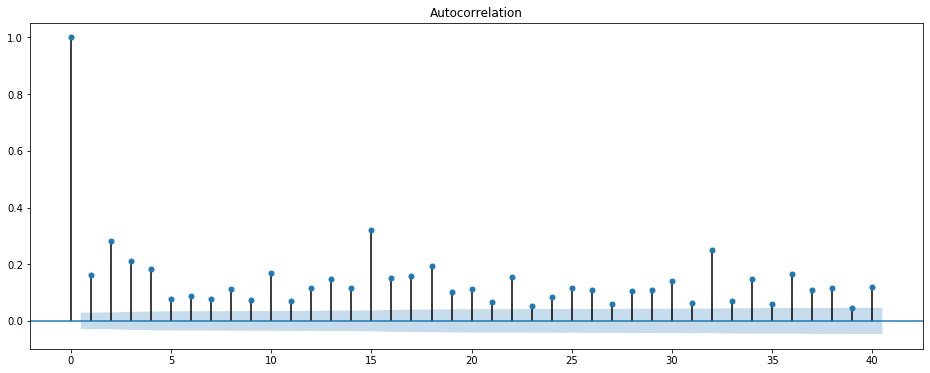

In [11]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(resid.values ** 2, lags=40, ax=ax1)

In [25]:
from statsmodels.stats.stattools import jarque_bera
_, jbpv, *_ = jarque_bera(returns.values)
print ('pvalue-->',jbpv)

pvalue--> [0.]


In [12]:
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, StudentsT, ConstantMean

In [13]:
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
print (res.summary())
print (' ')
print ('The estimated parameters: ')
print ('----------------------------------------')
print (res.params)

Constant Mean - GARCH Model Results                         
Dep. Variable:              Log Return Rate   R-squared:                -5161710.184
Mean Model:                   Constant Mean   Adj. R-squared:           -5161710.184
Vol Model:                            GARCH   Log-Likelihood:               -38872.3
Distribution:      Standardized Student's t   AIC:                           77754.7
Method:                  Maximum Likelihood   BIC:                           77786.8
                                              No. Observations:                 4587
Date:                      Sun, Mar 08 2020   Df Residuals:                     4582
Time:                              21:50:17   Df Model:                            5
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            55.2241      0.539    102.

# $\begin{eqnarray} r_t & = & \mu + \epsilon_t + \theta\epsilon_{t-1} \\ \epsilon_t & = & \sigma_t e_t \\ \sigma^2_t & = & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1} \end{eqnarray}$

In [14]:
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
print(mu, theta, omega, alpha, beta)

0.0002615067034561962 -0.08874238195898754 0.0003888272659806071 0.5977012460803984 0.615133689641538


In [15]:
sigma_t = res.conditional_volatility.iloc[-1]
sigma_forecast = np.sqrt(omega + alpha * res.resid.iloc[-1] ** 2 + beta * res.conditional_volatility.iloc[-1] ** 2)
epsilon_t = sigma_t * np.random.standard_normal()
epsilon_forecast = sigma_forecast * np.random.standard_normal()
returns_forecast = mu + epsilon_forecast + theta * epsilon_t
returns_forecast

36.79880283511403

In [16]:
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.iloc[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool

In [17]:
train_returns = pd.DataFrame(np.log(test_data['Open']).diff().dropna())
train_returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)

### Prediction results of the ARMA-GARCH model

<Figure size 1008x576 with 0 Axes>

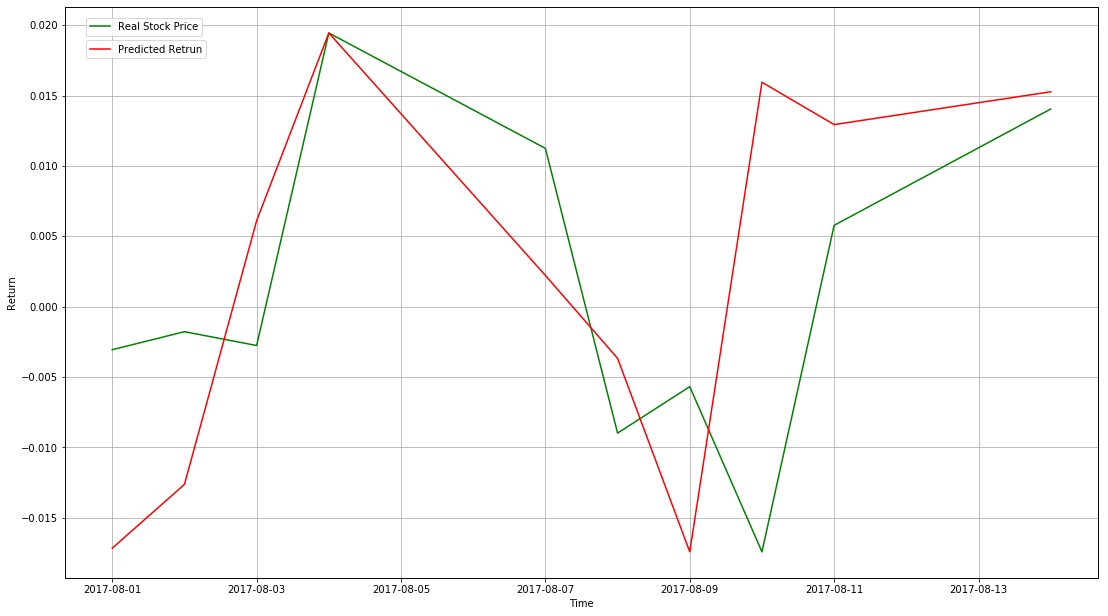

In [30]:
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(data.index[-73:-63], train_returns['Log Return Rate'][:10], color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(data.index[-73:-63],returns_predict(10), color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))

###  Prediction results of General Motors Company using the ARMA-GARCH model

C:\Users\JinYC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 1008x576 with 0 Axes>

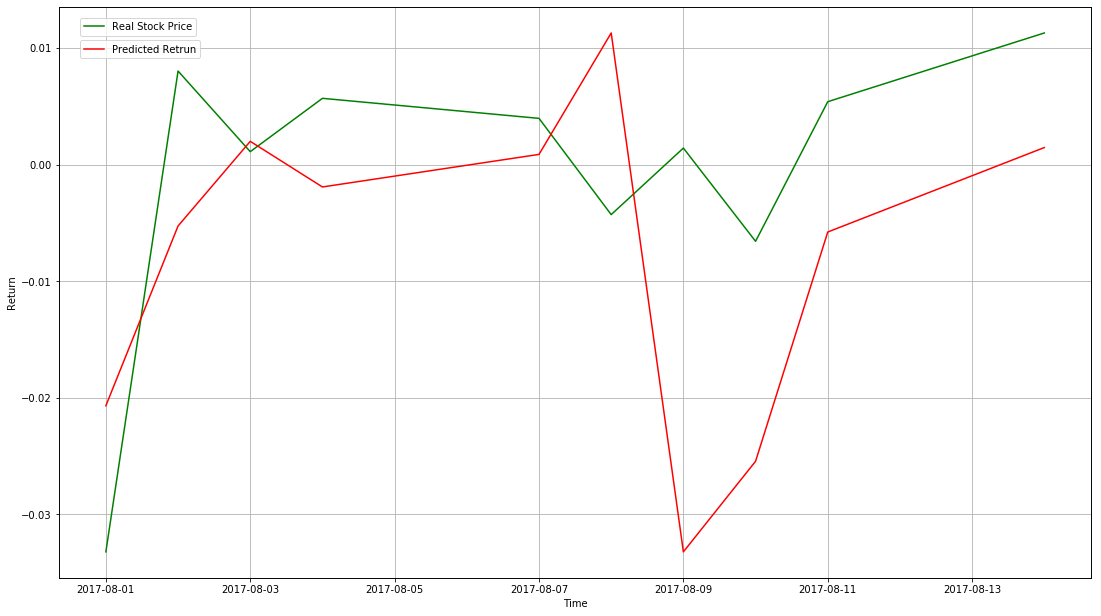

In [143]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/gm.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
train_data, test_data = data[0:-73], data[-73:]
returns = pd.DataFrame(np.log(train_data['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
arma_mod01 = sm.tsa.ARMA(returns, (1, 0)).fit()
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.iloc[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool
train_returns = pd.DataFrame(np.log(test_data['Open']).diff().dropna())
train_returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(data.index[-73:-63], train_returns['Log Return Rate'][:10], color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(data.index[-73:-63],returns_predict(10), color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))

### Prediction results of IBM using the ARMA-GARCH model

C:\Users\JinYC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 1008x576 with 0 Axes>

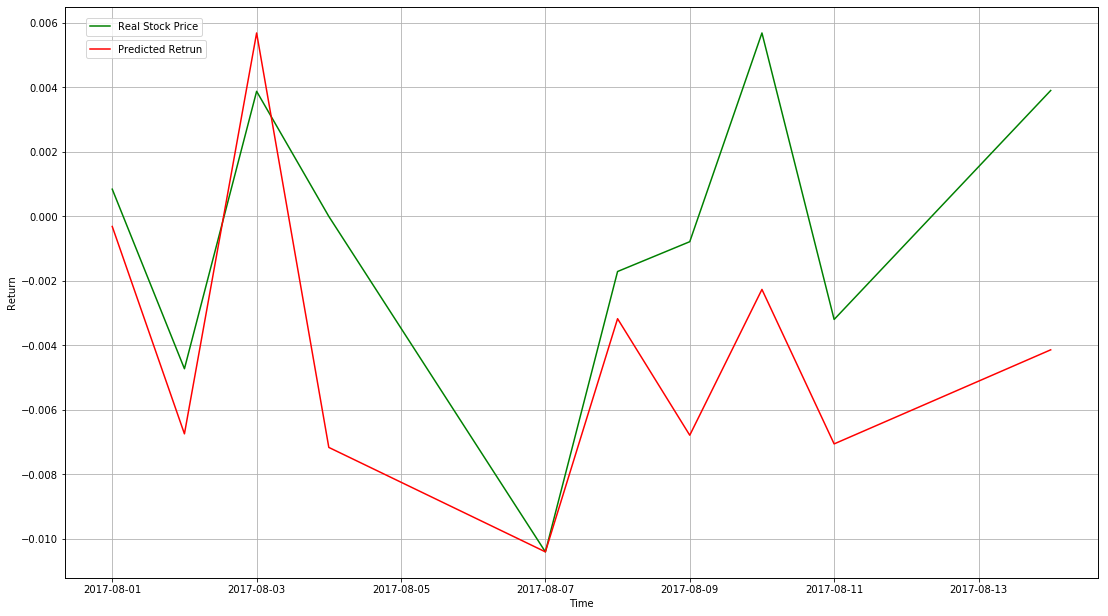

In [51]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/ibm.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
train_data, test_data = data[0:-73], data[-73:]
returns = pd.DataFrame(np.log(train_data['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
arma_mod01 = sm.tsa.ARMA(returns, (1, 0)).fit()
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.iloc[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool
train_returns = pd.DataFrame(np.log(test_data['Open']).diff().dropna())
train_returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(data.index[-73:-63], train_returns['Log Return Rate'][:10], color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(data.index[-73:-63],returns_predict(10), color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))

### Prediction results of Microsoft using the ARMA-GARCH model

C:\Users\JinYC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JinYC\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<Figure size 1008x576 with 0 Axes>

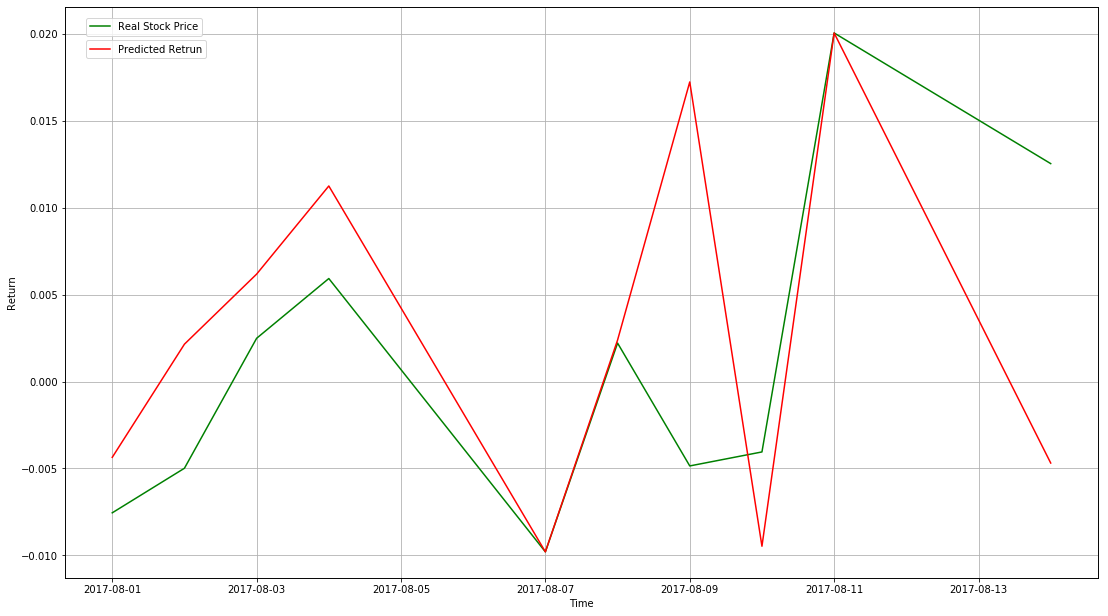

In [120]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/msft.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
train_data, test_data = data[0:-73], data[-73:]
returns = pd.DataFrame(np.log(train_data['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
arma_mod01 = sm.tsa.ARMA(returns, (1, 0)).fit()
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.iloc[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool
train_returns = pd.DataFrame(np.log(test_data['Open']).diff().dropna())
train_returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(data.index[-73:-63], train_returns['Log Return Rate'][:10], color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(data.index[-73:-63],returns_predict(10), color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))

### Prediction results of Tesla using the ARMA-GARCH model

C:\Users\JinYC\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 1008x576 with 0 Axes>

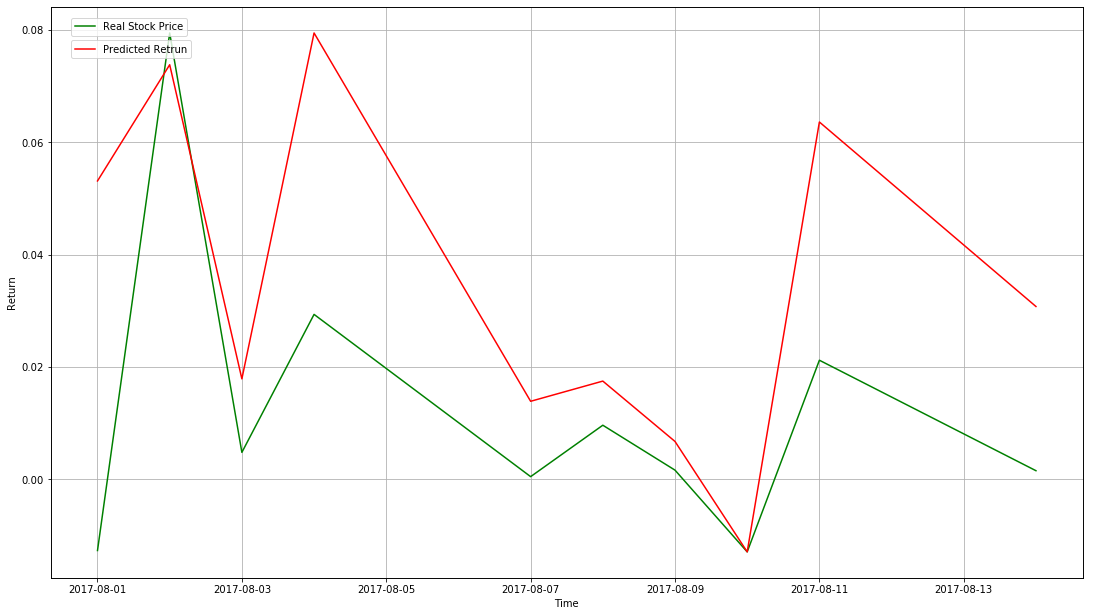

In [154]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/tsla.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
train_data, test_data = data[0:-73], data[-73:]
returns = pd.DataFrame(np.log(train_data['Open']).diff().dropna())
returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
arma_mod01 = sm.tsa.ARMA(returns, (1, 0)).fit()
arch_mod = ConstantMean(returns)
arch_mod.volatility = GARCH(1,0,1)
arch_mod.distribution = StudentsT()
res=arch_mod.fit(update_freq=5, disp='off')
mu = arma_mod01.params[0]
theta = arma_mod01.params[1]
omega = res.params[1]
alpha = res.params[2]
beta = res.params[3]
def returns_predict(period):
    returns_pool = []
    for i in range(period):
        sigma_t = res.conditional_volatility.iloc[-1]
        epsilon_t = sigma_t * np.random.standard_normal()
        sigma_forecast = np.sqrt(omega + alpha * epsilon_t ** 2 + beta * sigma_t ** 2)
        epsilon_forecast = sigma_forecast * np.random.standard_normal()
        returns_forecast = mu + epsilon_forecast + theta * epsilon_t
        returns_pool.append(returns_forecast)
        sigma_t = sigma_forecast
    return returns_pool
train_returns = pd.DataFrame(np.log(test_data['Open']).diff().dropna())
train_returns.rename(columns={'Open':'Log Return Rate'}, inplace=True)
plt.figure(figsize=(14,8))
fig = plt.figure()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
ax.plot(data.index[-73:-63], train_returns['Log Return Rate'][:10], color='green', label = 'Real Stock Price')
ax2 = ax.twinx()
ax2.plot(data.index[-73:-63],returns_predict(10), color='red',label = 'Predicted Retrun')
ax.legend(loc = (0.02, 0.95))
ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Return")
ax2.set_yticks([])
ax2.legend(loc = (0.02, 0.91))